# Import Libraries

In [1]:
import pandas as pd 
import numpy as np
import random
import matplotlib.pyplot as plt

# Import Data

In [2]:
# Import Data
restaurant_all = pd.read_csv(r"D:\Tony\Programming\Datasets\Yelp\yelp_restaurant.csv", encoding='utf-8')
restaurant = pd.read_csv(r"D:\Tony\Programming\Datasets\Yelp\yelp_restaurant_2019.csv", encoding='utf-8')
reviews = pd.read_csv(r"D:\Tony\Programming\Datasets\Yelp\yelp_reviews_2018.csv", encoding='utf-8')

# Calculate Features

### Transform continuous output to classes

In [3]:
# Create target labels
ppl80 = restaurant['popularity'].quantile(q=0.8)
ppl60 = restaurant['popularity'].quantile(q=0.6)
ppl40 = restaurant['popularity'].quantile(q=0.4)
ppl20 = restaurant['popularity'].quantile(q=0.2)

print(ppl80, ppl60, ppl40, ppl20)

conditions = [
    (restaurant['popularity'] >= ppl80),
    (restaurant['popularity'] < ppl80) & (restaurant['popularity'] >= ppl60),
    (restaurant['popularity'] < ppl60) & (restaurant['popularity'] >= ppl40),
    (restaurant['popularity'] < ppl40) & (restaurant['popularity'] >= ppl20),
    (restaurant['popularity'] < ppl20)
]

choices = [5,4,3,2,1]

restaurant['pop_label'] = np.select(condlist=conditions, choicelist=choices)

2.959556950917159 1.464816384890813 0.4882721282969379 -0.7434447729291692


(array([4.000e+00, 1.400e+01, 5.400e+01, 2.010e+02, 4.900e+02, 9.920e+02,
        2.357e+03, 2.826e+03, 4.343e+03, 5.565e+03, 3.866e+03, 2.780e+03,
        1.859e+03, 1.160e+03, 6.480e+02, 3.440e+02, 1.200e+02, 4.300e+01,
        1.000e+01, 7.000e+00]),
 array([-8.01874897, -7.06204014, -6.10533131, -5.14862248, -4.19191365,
        -3.23520482, -2.27849599, -1.32178716, -0.36507833,  0.5916305 ,
         1.54833933,  2.50504816,  3.46175699,  4.41846582,  5.37517465,
         6.33188349,  7.28859232,  8.24530115,  9.20200998, 10.15871881,
        11.11542764]),
 <a list of 20 Patch objects>)

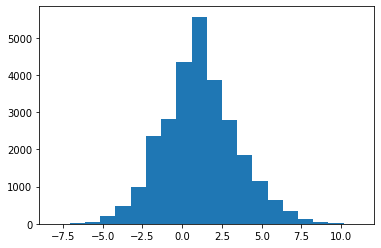

In [4]:
plt.hist(restaurant['popularity'], bins=20)

In [5]:
len(restaurant[restaurant['pop_label'] == 1]), len(restaurant[restaurant['pop_label'] == 2]), \
len(restaurant[restaurant['pop_label'] == 3]), len(restaurant[restaurant['pop_label'] == 4]), \
len(restaurant[restaurant['pop_label'] == 5])

(5537, 5522, 5292, 5778, 5554)

### Calculate average city review counts

In [6]:
# Join df
res_join = pd.merge(restaurant, restaurant_all, how='inner', on=['business_id'])
len(restaurant), len(res_join)

(27683, 27683)

In [7]:
# Calculate overall city review counts
cities = res_join.groupby(['city', 'state']).agg({'count':'sum'})

# Combine calculations with restaurant df
res_join = pd.merge(res_join, cities, how='left', on=['city', 'state'])

In [8]:
res_join.shape

(27683, 19)

In [9]:
res_join.head()

,business_id,stars_x,count_x,popularity,pop_label,name,address,city,state,postal_code,latitude,longitude,stars_y,review_count,is_open,attributes,categories,hours,count_y
0,--1UhMGODdWsrMastO9DZw,4.000000,3,1.098612,3,The Spicy Amigos,821 4 Avenue SW,Calgary,AB,T2P 0K5,51.049673,-114.079977,4.0,27,1,"{'RestaurantsAttire': ""u'casual'"", 'GoodForMea...","Restaurants, Mexican","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'...",4905
1,--6MefnULPED_I942VcFNA,1.636364,11,-3.269857,1,John's Chinese BBQ Restaurant,"328 Highway 7 E, Chalmers Gate 11, Unit 10",Richmond Hill,ON,L4B 3P7,43.841694,-79.399755,3.0,55,1,"{'NoiseLevel': ""'average'"", 'RestaurantsPriceR...","Chinese, Restaurants","{'Monday': '11:0-22:30', 'Tuesday': '11:0-22:3...",2101
2,--9e1ONYQuAa-CB_Rrw7Tw,4.083333,132,5.289702,5,Delmonico Steakhouse,3355 Las Vegas Blvd S,Las Vegas,NV,89109,36.123183,-115.169190,4.0,1759,1,"{'Alcohol': ""'full_bar'"", 'BusinessParking': ""...","Seafood, Cajun/Creole, Restaurants, Steakhouses","{'Monday': '17:0-22:0', 'Tuesday': '17:0-22:0'...",168192
3,--DaPTJW3-tB1vP-PfdTEg,4.333333,3,1.464816,4,Sunnyside Grill,1218 Saint Clair Avenue W,Toronto,ON,M6E,43.677807,-79.444674,4.0,51,1,"{'RestaurantsReservations': 'False', 'NoiseLev...","Restaurants, Breakfast & Brunch","{'Monday': '7:0-15:0', 'Tuesday': '7:0-15:0', ...",33883
4,--FBCX-N37CMYDfs790Bnw,3.782609,23,2.453865,4,The Bar At Bermuda & St. Rose,11624 Bermuda Rd,Henderson,NV,89052,35.978679,-115.155057,4.0,166,1,"{'RestaurantsGoodForGroups': 'True', 'Restaura...","American (New), Nightlife, Beer, Wine & Spirit...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",17221


# Combine Features to One Dataframe

### Train test split

In [10]:
# Define list of restaurants
list_of_restaurants = reviews['business_id'].unique()

# Sample from list
SAMPLE = random.sample(range(len(list_of_restaurants)), round(0.8*len(list_of_restaurants)))
list_of_restaurants_train = list_of_restaurants[SAMPLE]
list_of_restaurants_test = list(set(list_of_restaurants)-set(list_of_restaurants[SAMPLE]))
feature_train = reviews[reviews['business_id'].isin(list_of_restaurants_train)].iloc[:,[0,1,2,3,4]]
feature_test = reviews[reviews['business_id'].isin(list_of_restaurants_test)].iloc[:,[0,1,2,3,4]]

In [11]:
feature_train.shape, feature_test.shape

((539587, 5), (136549, 5))

### Combine review features with restaurant features

In [12]:
feature_train = pd.merge(feature_train, res_join, how='left', on=['business_id']) 
feature_test = pd.merge(feature_test, res_join, how='left', on=['business_id'])

### Select required columns

In [13]:
feature_train = feature_train.iloc[:,[0,1,2,3,4,5,6,7,8,-1]]
feature_train.columns = ['business_id', 'user_id', 'rev_stars', 'like', 'text', 
                         'res_stars', 'res_count', 'pop', 'pop_label', 'city_count']
feature_test = feature_test.iloc[:,[0,1,2,3,4,5,6,7,8,-1]]
feature_test.columns = ['business_id', 'user_id', 'rev_stars', 'like', 'text', 
                        'res_stars', 'res_count', 'pop', 'pop_label', 'city_count']

In [14]:
feature_train.shape, feature_test.shape

((539587, 10), (136549, 10))

### Remove NAs

In [15]:
feature_train = feature_train.dropna().reset_index().drop(columns=['index'])
feature_train.shape

(526780, 10)

In [16]:
feature_test = feature_test.dropna().reset_index().drop(columns=['index'])
feature_test.shape

(133220, 10)

# Add Extra Features

### Length of reviews

In [17]:
feature_train['text_len'] = feature_train['text'].str.split().str.len()
feature_test['text_len'] = feature_test['text'].str.split().str.len()

# Export Features

In [18]:
feature_train.to_csv(r'D:\Tony\Programming\Datasets\Yelp\yelp_feature_train.csv', index=False, encoding='utf-8')
feature_test.to_csv(r'D:\Tony\Programming\Datasets\Yelp\yelp_feature_test.csv', index=False, encoding='utf-8')